In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!ls "/content/drive/MyDrive/DeepLearning/Common Literacy"

CommonLiteracyBertModels.ipynb
Common_Literacy_BOW_TFIDF_AvgW2V100D.ipynb
Common_Literacy_BOW_TFIDF_AvgW2V100D_SVD.ipynb
Common_Literacy_BOW_TFIDF_AVGW2V300D.ipynb
CommonLiteracy_CNN_Model.ipynb
Dataset


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Gensim Models word2vec
import gensim
from gensim.models import Word2Vec
%matplotlib inline

In [5]:
train ='/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/train.csv'
test = '/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/test.csv'

In [6]:
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

In [7]:
print("This is train dataset")
print(df_train.head(2))
print(df_train.columns)
print("="*100)
print("This is test dataset")
print(df_test.head(2))
print(df_test.columns)

This is train dataset
          id url_legal  ...    target standard_error
0  c12129c31       NaN  ... -0.340259       0.464009
1  85aa80a4c       NaN  ... -0.315372       0.480805

[2 rows x 6 columns]
Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error'], dtype='object')
This is test dataset
          id  ...                                            excerpt
0  c0f722661  ...  My hope lay in Jack's promise that he would ke...
1  f0953f0a5  ...  Dotty continued to go to Mrs. Gray's every nig...

[2 rows x 4 columns]
Index(['id', 'url_legal', 'license', 'excerpt'], dtype='object')


Text(0, 0.5, 'Probability Density')

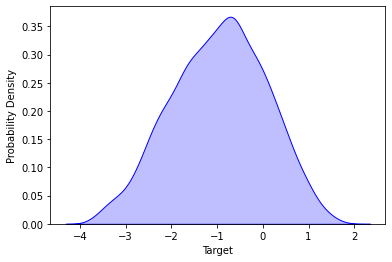

In [8]:
# plotting the KDE plot fot check the distribution of the dependents
import seaborn as sns

sns.kdeplot(df_train['target'], color='b', shade=True, Label='Target')
# Setting the X and Y Label
plt.xlabel('Target')
plt.ylabel('Probability Density')

In [9]:
# importing stopwords from nltk library
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopword = stopwords.words('english')
print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'ag

### Pretrained Glove Vector assignment

In [11]:
# Refer this for step by step method https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory

!wget http://nlp.stanford.edu/data/glove.6B.zip # get the glove vector from stanford library

--2021-07-05 06:47:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-05 06:47:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-05 06:47:04--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [13]:
#unzip the downloaded glove vectors to drive
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [14]:
# creating the dictionary if word and vectors
print('Indexing word vectors.')

glove_100d = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_100d[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_100d))

Indexing word vectors.
Found 400000 word vectors.


In [15]:
# creating a set of the keys from glove dictionary
glove_words = set(glove_100d.keys())

In [16]:
# checking the dictionary word shape
print(glove_100d['the'].shape)

(100,)


In [17]:
# code to check for 3 dictionary values in text.
# import itertools
# # Initialize limit 
# N = 3
    
# # Using islice() + items() 
# # Get first N items in dictionary 
# out = dict(itertools.islice(glove_100d.items(), N)) 

# # printing result  
# print("Dictionary limited by K is : " + str(out))

### Cleaning the text data for any special characters and numerical characters

In [18]:
def testpreprocess(phrase):
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    return phrase

In [19]:
preprocessed_excerpt = []
for sentence in tqdm(df_train['excerpt'].values):
  sent = testpreprocess(sentence)
  sent = sent.lower().strip()
  sent = ' '.join(e for e in sent.split(" ") if e not in stopword)
  preprocessed_excerpt.append(sent)

df_train['cleaned_excerpt'] = preprocessed_excerpt

100%|██████████| 2834/2834 [00:01<00:00, 2125.15it/s]


In [ ]:
# print(df_train['excerpt'].values[0])
# print("="*100)
# print(df_train['cleaned_excerpt'].values[:100])

In [20]:
print(df_train.columns)

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error',
       'cleaned_excerpt'],
      dtype='object')


### Glove Average Word 2 Vec Model

In [21]:
# Function to calculate the average word to vec for each sentence paragraph in the series
def Avg_W2V(selfie): # give a pandas series into
  # compute average word2vec for each review.
  AvgW2V_list = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(selfie.values): # for each review/sentence
      vector = np.zeros(100) # as word vectors are of zero length
      cnt_words =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if word in glove_words: # this is set of glove vector keys
              vector += glove_100d[word] # this is adding the vector of 100 dimensions
              cnt_words += 1
      if cnt_words != 0:
          vector /= cnt_words
      AvgW2V_list.append(vector)
      # avgW2V_dict[sentence] = vector
  AvgW2V_Array = np.stack(AvgW2V_list, axis=0) # used to flatten the vector to one axis and convert the list of list to array
  return AvgW2V_Array


### Latent Dirichlet Allocation

In [22]:
lda_vectorizer = CountVectorizer()
corpus = lda_vectorizer.fit_transform(df_train['cleaned_excerpt'])
feature_names = lda_vectorizer.get_feature_names()
print(corpus.shape)
print(feature_names)

lda_model = LDA(n_components=6,max_iter=20,random_state=20)
X_topics = lda_model.fit_transform(corpus)
topic_words = lda_model.components_

(2834, 26660)
['00', '000', '000th', '001', '02', '03', '034', '04', '049', '06', '07', '070', '090', '0v', '10', '100', '1000', '100lbs', '1011', '1012', '1016', '1024', '105', '1050', '106', '108', '1095', '10am', '10th', '10x10', '11', '111', '112', '115', '1154', '116', '11a', '11and', '11b', '11th', '12', '120', '1200', '1223', '125', '127', '128', '129', '1291', '1299', '12th', '12x13', '13', '130', '1305', '132', '1328', '1337', '1340', '136', '1362', '1389', '13th', '13x14', '14', '140', '141', '1425', '142nd', '143', '1439', '144', '1453', '148', '149', '1490s', '1492', '1496', '14th', '15', '150', '1501', '1506', '1513', '1519', '1524', '1528', '1536', '1556', '156', '1580', '1585', '1592', '1598', '15th', '16', '1600', '1600s', '1607', '1608', '1610', '1613', '1615', '1624', '165', '1651', '1652', '165546', '167', '1670', '1683', '1688', '1699', '16ft', '16s', '16th', '17', '1700', '1700s', '1701', '1705', '171', '1710', '173', '1734', '1754', '1756', '1757', '1759', '1760',

In [23]:
n_top_words = 4

for i, topic_dist in enumerate(topic_words):
  print(topic_dist)
  sorted_topic_dist = np.argsort(topic_dist)
  print("="*100)
  print(sorted_topic_dist)
  topic_words_new = np.array(feature_names)[sorted_topic_dist]
  topic_words_new = topic_words_new[:-n_top_words:-1]
  print("Topic",str(i+1),topic_words_new)

[ 0.16674001 70.08362254  0.16666674 ...  0.16666668  1.16108188
  0.16666674]
[ 3141 24297 24298 ... 10776 17501 16629]
Topic 1 ['one' 'people' 'great']
[3.1657928  0.16734336 0.16805114 ... 0.1666667  0.16666686 0.16666678]
[ 3141 24297 24298 ... 20404 24812 16629]
Topic 2 ['one' 'two' 'room']
[0.16666679 0.1674839  0.16666684 ... 4.16647702 0.16666696 0.16666685]
[24297 24298  6202 ... 26429 14149 16629]
Topic 3 ['one' 'little' 'would']
[ 0.16736111 90.27994246  2.16528173 ...  0.16666668  0.17225059
  0.16666673]
[ 3141  6202  7035 ...  6991  1265 25285]
Topic 4 ['used' 'also' 'different']
[0.1667725  0.16685787 0.16666672 ... 0.1668562  0.16666675 1.16666606]
[ 3141 24297 24298 ... 16629 14149 20638]
Topic 5 ['said' 'little' 'one']
[0.16666678 4.13474987 0.16666684 ... 0.16666671 0.16666695 0.16666684]
[ 3141 17277 16663 ... 14497 14030 16629]
Topic 6 ['one' 'like' 'made']


### Splitting data into Train and cross validation(or test): Stratified Sampling

In [24]:
Y = df_train['target']
X = df_train['cleaned_excerpt']

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

In [26]:
print(X_train.head(5))

1940    tell truth sympathies divided little bright ey...
992     human brain arguably complex structure known s...
2233    public buildings gardens worthy first city eur...
1114    truth matter europe requirements next three fo...
1088    anu got ready jiffy gulped milk without fuss e...
Name: cleaned_excerpt, dtype: object


### TF-IDF processing of text

In [27]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),min_df=5)
vectorizer.fit(X_train)
feature_names = vectorizer.get_feature_names()

X_train_excerpt_tfidf = vectorizer.transform(X_train)
X_test_excerpt_tfidf = vectorizer.transform(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_tfidf.shape, Y_train.shape)
print(X_test_excerpt_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(1898, 5487) (1898,)
(936, 5487) (936,)


### Bag of Words 

In [28]:
vectorizer = CountVectorizer(ngram_range=(1, 2),min_df=5)
vectorizer.fit(X_train)
feature_names = vectorizer.get_feature_names()

X_train_excerpt_bow = vectorizer.transform(X_train)
X_test_excerpt_bow = vectorizer.transform(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_bow.shape, Y_train.shape)
print(X_test_excerpt_bow.shape, Y_test.shape)
print("="*100)

After vectorizations
(1898, 5487) (1898,)
(936, 5487) (936,)


### Average Word to Vector Representation for 100 dimension

In [29]:
X_train_excerpt_avgw2v = Avg_W2V(X_train)
X_test_excerpt_avgw2v = Avg_W2V(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_avgw2v.shape, Y_train.shape)
print(X_test_excerpt_avgw2v.shape, Y_test.shape)
print("="*100)

100%|██████████| 936/936 [00:00<00:00, 3942.35it/s]

After vectorizations
(1898, 100) (1898,)
(936, 100) (936,)


## Truncated SVD Implementation

### Truncated SVD for TF-IDF

Number of components = 4 and explained variance = 0.018260698994339505
Number of components = 10 and explained variance = 0.03707902941630953
Number of components = 15 and explained variance = 0.0503360130779199
Number of components = 20 and explained variance = 0.06202373058401123
Number of components = 50 and explained variance = 0.11962525575750566
Number of components = 100 and explained variance = 0.19630414753980072
Number of components = 150 and explained variance = 0.2613236316462991
Number of components = 200 and explained variance = 0.3191154885456526
Number of components = 500 and explained variance = 0.5757046440400243
Number of components = 700 and explained variance = 0.6950757875350853
Number of components = 800 and explained variance = 0.7442749066668528
Number of components = 900 and explained variance = 0.7875743110900734
Number of components = 1000 and explained variance = 0.8256923268498717
Number of components = 1500 and explained variance = 0.9541700982932027
Numb

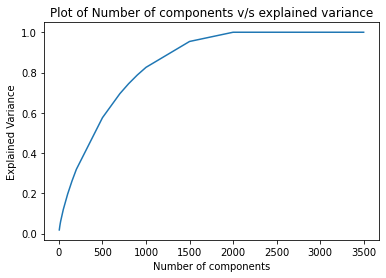

In [33]:
from sklearn.decomposition import TruncatedSVD

# Program to find the optimal number of components for Truncated SVD
n_comp = [4,10,15,20,50,100,150,200,500,700,800,900,1000,1500,2000,2500,3000,3500] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x,n_iter=20)
    svd.fit(X_train_excerpt_tfidf)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [37]:
best_SVD = TruncatedSVD(n_components=2000,n_iter=20)
svd.fit(X_train_excerpt_tfidf)

X_train_excerpt_tfidf_svd = svd.transform(X_train_excerpt_tfidf)
X_test_excerpt_tfidf_svd = svd.transform(X_test_excerpt_tfidf)

<class 'numpy.ndarray'>


### Truncated SVD for Avg Word2Vec

Number of components = 4 and explained variance = 0.45615172384169617
Number of components = 10 and explained variance = 0.6447749397284429
Number of components = 15 and explained variance = 0.7188199320550506
Number of components = 20 and explained variance = 0.7716896341381512
Number of components = 30 and explained variance = 0.8411490915095859
Number of components = 40 and explained variance = 0.8867177033508569
Number of components = 50 and explained variance = 0.9201291179489458
Number of components = 60 and explained variance = 0.9463766270949768
Number of components = 70 and explained variance = 0.9675230650838385
Number of components = 80 and explained variance = 0.9837484020961753
Number of components = 90 and explained variance = 0.9947961338067497
Number of components = 95 and explained variance = 0.9981991517059126


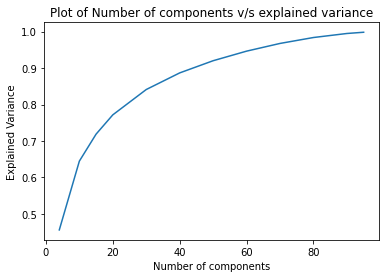

In [32]:
# Program to find the optimal number of components for Truncated SVD
n_comp = [4,10,15,20,30,40,50,60,70,80,90,95] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    svd = TruncatedSVD(n_components=x)
    svd.fit(X_train_excerpt_avgw2v)
    explained.append(svd.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

# Various Models

### Linear Regression

In [35]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train_excerpt_tfidf_svd, Y_train, cv = 5)
print(scores,np.mean(scores),np.std(scores))
lr.fit(X_train_excerpt_tfidf_svd,Y_train)

Y_pred = lr.predict(X_test_excerpt_tfidf_svd)

mse = metrics.mean_squared_error(Y_test,Y_pred)
print("This is root mean square error: ", np.sqrt(mse))

[0.23311883 0.25558502 0.27617541 0.31488407 0.32585337] 0.2811233415627923 0.03499052377589974
This is root mean square error:  0.8901689329199378


In [ ]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train_excerpt_bow, Y_train, cv = 5)
print(scores,np.mean(scores),np.std(scores))
lr.fit(X_train_excerpt_bow,Y_train)

Y_pred = lr.predict(X_test_excerpt_bow)

mse = metrics.mean_squared_error(Y_test,Y_pred)
print("This is root mean square error: ", np.sqrt(mse))

[0.17554906 0.13979032 0.09712838 0.28079012 0.09840082] 0.15833174179229256 0.06778471830820666
This is root mean square error:  0.994041933660022


### Function to run all models together

In [38]:
# data = {"Bag of Words":(X_train_excerpt_bow,X_test_excerpt_bow),"TF-IDF":(X_train_excerpt_tfidf,X_test_excerpt_tfidf),"Avg Word2Vec":(X_train_excerpt_avgw2v,X_test_excerpt_avgw2v)}
data = {"TF-IDF":(X_train_excerpt_tfidf,X_test_excerpt_tfidf),"TF-IDF-SVD":(X_train_excerpt_tfidf_svd,X_test_excerpt_tfidf_svd)}

def modelfunction(modelname,data,Y_train,Y_test,param):
  for key,value in tqdm(data.items()):
    train = value[0]
    test = value[1]
    gscv = GridSearchCV(modelname, param_grid=param,cv=5,verbose=10,n_jobs=-1)
    results = gscv.fit(train, Y_train)
    best_estimate = gscv.best_estimator_

    Y_pred_train = best_estimate.predict(train)
    train_residuals = Y_train - Y_pred_train
    Y_pred_test = best_estimate.predict(test)
    test_residuals = Y_test - Y_pred_test
    mse_train = metrics.mean_squared_error(Y_train,Y_pred_train)
    mse_test = metrics.mean_squared_error(Y_test,Y_pred_test)

    print("-"*100)
    print("The model is run on {}: ".format(key))
    print("="*100)
    print(best_estimate)
    print("*"*50)
    print("Root Mean squared Error Train for {}: ".format(key), np.sqrt(mse_train))
    print("Root Mean squared Error Test for {}: ".format(key), np.sqrt(mse_test))

    plt.subplot(1,2,1)
    plt.scatter(train_residuals.index,train_residuals)
    plt.title("Train Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')

    plt.subplot(1,2,2)
    plt.scatter(test_residuals.index,test_residuals)
    plt.title("Test Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')
    plt.show()

### Lasso Regression

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1922s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    9.0s finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.6724488208971754
Root Mean squared Error Test for TF-IDF:  0.8353797798641195


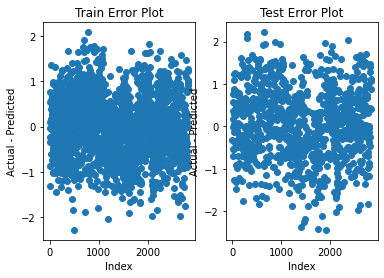

 50%|█████     | 1/2 [00:09<00:09,  9.66s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1918s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    3.9s finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF-SVD: 
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for TF-IDF-SVD:  0.7297890036746537
Root Mean squared Error Test for TF-IDF-SVD:  0.7898350798310246


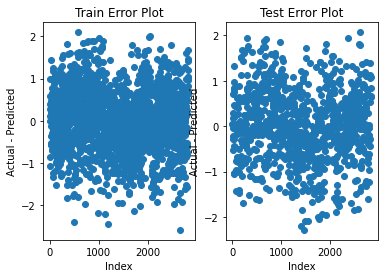

100%|██████████| 2/2 [00:14<00:00,  7.06s/it]


In [39]:
lasso_params = {'alpha':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]}
lasso = Lasso()

modelfunction(lasso,data,Y_train,Y_test,lasso_params)

### Ridge Regression

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0342s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0905s.) Setting batch_size=4.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1562s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    0.9s finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
Ridge(alpha=0.8, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.4084628399391685
Root Mean squared Error Test for TF-IDF:  0.7699101103562795


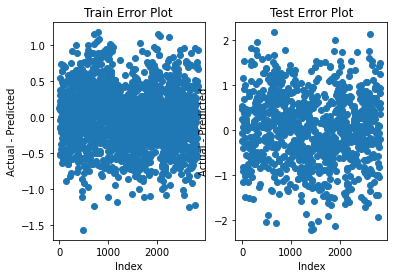

 50%|█████     | 1/2 [00:01<00:01,  1.17s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   14.3s finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF-SVD: 
Ridge(alpha=0.8, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
**************************************************
Root Mean squared Error Train for TF-IDF-SVD:  0.4084633287815454
Root Mean squared Error Test for TF-IDF-SVD:  0.7699017089604888


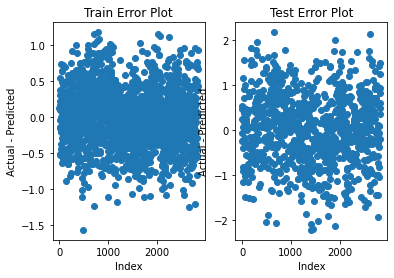

100%|██████████| 2/2 [00:16<00:00,  8.17s/it]


In [40]:
ridge_params = {'alpha':[0.35,0.4,0.5,0.6,0.8,1.0,1.5,2.0,3.0,4>0,5.0,6.0,10.0,15.0,20.0]}
ridge = Ridge()

modelfunction(ridge,data,Y_train,Y_test,ridge_params)

### SGD Regressor

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    4.8s finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
SGDRegressor(alpha=1e-05, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.8408604574889446
Root Mean squared Error Test for TF-IDF:  0.9272149523522746


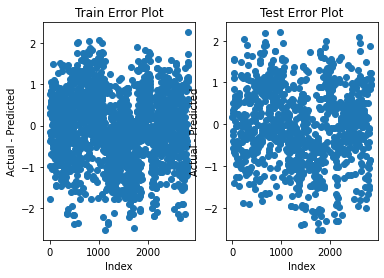

 50%|█████     | 1/2 [00:05<00:05,  5.21s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   43.9s finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF-SVD: 
SGDRegressor(alpha=1e-05, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
**************************************************
Root Mean squared Error Train for TF-IDF-SVD:  0.8364318818826193
Root Mean squared Error Test for TF-IDF-SVD:  0.9146481378610546


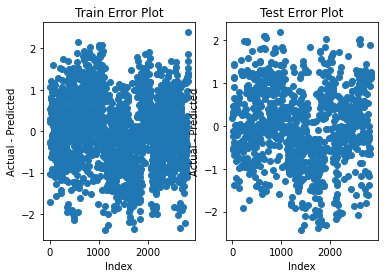

100%|██████████| 2/2 [00:50<00:00, 25.30s/it]


In [41]:
SGD_params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,0.2,0.3],'penalty':['l1','l2']}
SGD = SGDRegressor()

modelfunction(SGD,data,Y_train,Y_test,SGD_params)

### KNN Regression

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0836s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1993s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    1.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:414: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=40, p=2,
                    weights='uniform')
**************************************************
Root Mean squared Error Train for TF-IDF:  0.8251481499750533
Root Mean squared Error Test for TF-IDF:  0.8666546521803385


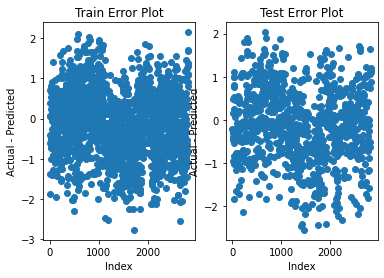

 50%|█████     | 1/2 [00:02<00:02,  2.25s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  1.6min finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF-SVD: 
KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=40, p=2,
                    weights='uniform')
**************************************************
Root Mean squared Error Train for TF-IDF-SVD:  0.8251481499750533
Root Mean squared Error Test for TF-IDF-SVD:  0.8666546521803385


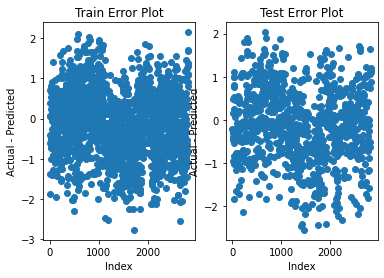

100%|██████████| 2/2 [02:03<00:00, 61.67s/it]


In [42]:
KNN_params = {'n_neighbors':[7,8,10,15,20,30,40,50,80,90,100],'algorithm':['kd_tree']}
KNN = KNeighborsRegressor()

modelfunction(KNN,data,Y_train,Y_test,KNN_params)

### Linear SVR

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   47.5s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   50.4s finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.5058112447022104
Root Mean squared Error Test for TF-IDF:  0.7715712866157893


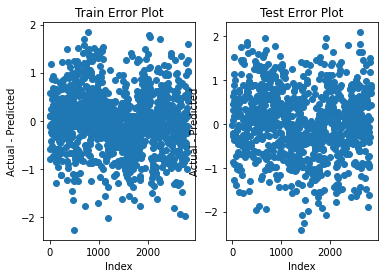

 50%|█████     | 1/2 [00:56<00:56, 56.28s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.0min finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF-SVD: 
SVR(C=0.5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for TF-IDF-SVD:  0.5058112447022103
Root Mean squared Error Test for TF-IDF-SVD:  0.7715712866157897


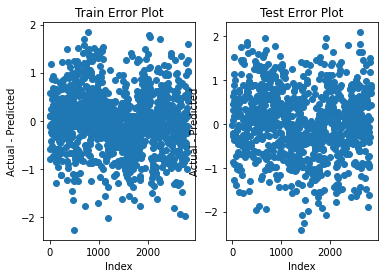

100%|██████████| 2/2 [04:25<00:00, 132.62s/it]


In [43]:
SVR_params = {'C':[0.1,0.2,0.3,0.4,0.5,1.0,1.5,2.0]}
LinearSVR = SVR(kernel='linear')

modelfunction(LinearSVR,data,Y_train,Y_test,SVR_params)

### RBF SVR

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.6min finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.5635345351620294
Root Mean squared Error Test for TF-IDF:  0.7786141868024906


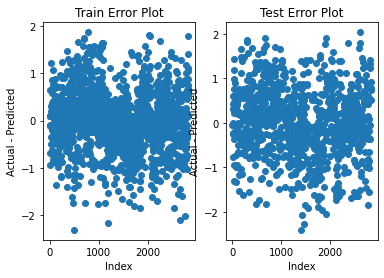

 50%|█████     | 1/2 [01:43<01:43, 103.46s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  5.8min finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF-SVD: 
SVR(C=600, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for TF-IDF-SVD:  0.4607876131571397
Root Mean squared Error Test for TF-IDF-SVD:  0.7719366965795336


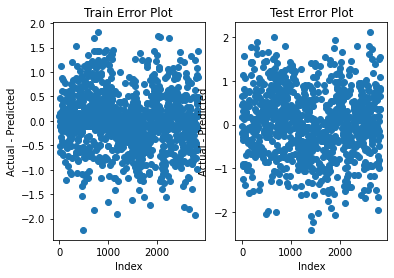

100%|██████████| 2/2 [07:59<00:00, 239.94s/it]


In [44]:
SVR_params = {'C':[10.0,20,30,50,80,100,150,200,300,400,500,600,700,900,1000]}
RBF_SVR = SVR(kernel='rbf',gamma="auto")

modelfunction(RBF_SVR,data,Y_train,Y_test,SVR_params)

### Random Forest

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 11.2min finished


----------------------------------------------------------------------------------------------------
The model is run on TF-IDF: 
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
**************************************************
Root Mean squared Error Train for TF-IDF:  0.31852871158633034
Root Mean squared Error Test for TF-IDF:  0.8546298450510859


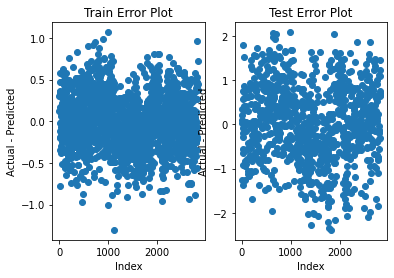

 50%|█████     | 1/2 [12:08<12:08, 728.88s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 25.3min


KeyboardInterrupt: ignored

In [45]:
RF_params = {'n_estimators':[10,20,30,50,70,90,100]}

RandomForest = RandomForestRegressor()
modelfunction(RandomForest,data,Y_train,Y_test,RF_params)

In [ ]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

xgb = XGBRegressor()
modelfunction(xgb,data,Y_train,Y_test,xgb_params)